<a href="https://colab.research.google.com/github/ashjostan7/Sudoku/blob/main/MNIST_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports:

In [ ]:
#Imports
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(f"Torch Version: {torch.__version__} \nTorchvision Version: {torchvision.__version__}")

Torch Version: 1.13.1+cu116 
Torchvision Version: 0.14.1+cu116


# Get Data:

In [ ]:
#Setting up the train data:
train_data = datasets.MNIST(root= '/content/drive/MyDrive/MNIST/data',
                            train = True,
                            download= True,
                            transform=ToTensor(),
                            target_transform=None)

test_data = datasets.MNIST(root = "/content/drive/MyDrive/MNIST/data",
                           train = False,
                            download= True,
                            transform=ToTensor(),
                            target_transform=None)

In [ ]:
#Check data

image, label = train_data[0]
#image, label = test_data[0]
print(f'Shape: {image.shape}')
print(f'label: {label}')
print(f'Image: {image}')


Shape: torch.Size([1, 28, 28])
label: 5
Image: tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          

In [ ]:
#Check data
print(f"Train: {len(train_data.data)} data points & {len(train_data.targets)} labels")
print(f"Test: {len(test_data.data)} data points & {len(test_data.targets)} labels")
print(f"Classes: {train_data.classes}")

Train: 60000 data points & 60000 labels
Test: 10000 data points & 10000 labels
Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


Image shape: torch.Size([1, 28, 28])


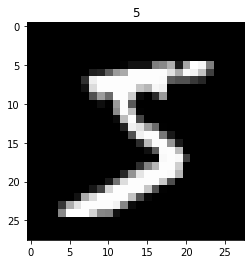

In [ ]:
#Visualise Data
import matplotlib.pyplot as plt
image, label = train_data[0]

plt.imshow(image.squeeze(), cmap="gray")
plt.title(label)
print(f"Image shape: {image.shape}")

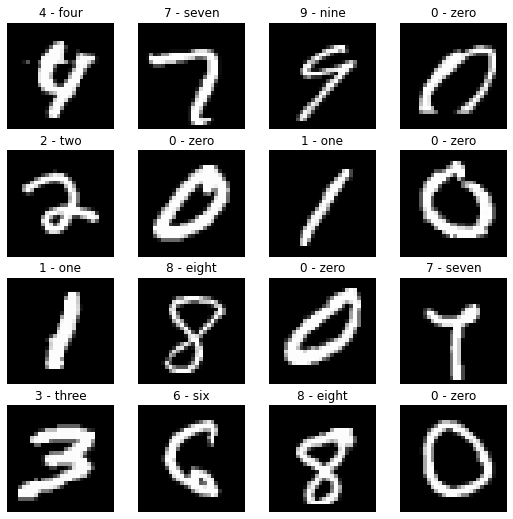

In [ ]:
rows , columns = 4,4
fig = plt.figure(figsize=(9, 9))
for i in range(1, rows * columns+1):
  rnd_index = torch.randint(0, len(train_data.data), size=[1]).item()
  #print(f"{i}: {rnd_index}")
  image, label = train_data[rnd_index]
  fig.add_subplot(rows, columns, i)
  plt.imshow(image.squeeze(), cmap='gray')
  plt.title(train_data.classes[label])
  plt.axis(False)


# DataLoader

In [ ]:
from torch.utils.data import DataLoader


#Hyper-parameter: Batch size
batch_size = 32

#Train
train_dataloader= DataLoader(train_data,
                             batch_size,
                             shuffle=True)
print(f"Train DataLoader:{train_dataloader}")
print(f"Train: {len(train_dataloader)} batches of batch size {batch_size}")


#Test
test_dataloader= DataLoader(test_data,
                             batch_size,
                             shuffle=True)
print(f"Train DataLoader:{test_dataloader}")
print(f"Train: {len(test_dataloader)} batches of batch size {batch_size}")


Train DataLoader:<torch.utils.data.dataloader.DataLoader object at 0x7f55ad2a0280>
Train: 1875 batches of batch size 32
Train DataLoader:<torch.utils.data.dataloader.DataLoader object at 0x7f55ad2a0f10>
Train: 313 batches of batch size 32


## Baseline Model

In [ ]:
from torch import nn

class MNISTv0(nn.Module):
  def __init__(self, input_shape, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features= input_shape, out_features= hidden_units),
        nn.Linear(in_features = hidden_units, out_features = output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)
class_names = train_data.classes

model_0 = MNISTv0(input_shape = 784, hidden_units= 10, output_shape= len(class_names))
model_0.to("cpu")

MNISTv0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

# Loss, optimizer and evaluation metrics

In [ ]:
#Acccuracy Function:
def accuracy_fn(labels, preds):
  correct = torch.eq(labels, preds).sum().item()
  acc = (correct/len(preds)) * 100
  return acc

# Optimiser:
optimiser = torch.optim.SGD(params = model_0.parameters(), lr = 0.01)
#Loss function:
loss_fn = nn.CrossEntropyLoss()


# Timer Utility
A function to time experiments

In [ ]:
import time

def get_time(start: float, end: float, device: torch.device = None):

  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time



# Train Loop: (CPU)

In [ ]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_start_time = time.time()

epochs = 10

for epoch in tqdm(range(epochs)):
  print(f"Epoch {epoch} \n -----------------------")

  train_loss = 0

  for batch, (X,y) in enumerate(train_dataloader):
    model_0.train()

    # 1. Forward Pass 
    y_pred = model_0(X)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss

    # 3. Optimizer zero grad
    optimiser.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimiser step
    optimiser.step()

    if batch % 800 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  #Avg train loss across batches
  train_loss /= len(train_dataloader)


  ### TESTING
  test_loss, test_acc = 0,0
  model_0.eval()
  with torch.inference_mode():
    for X,y in test_dataloader:

      #Predict:
      test_pred = model_0(X)

      #Calculate loss:
      test_loss += loss_fn(test_pred, y)

      #Calculate accuracy:
      test_acc += accuracy_fn(labels = y, preds = test_pred.argmax(dim=1))

      # Debug:
      #print(test_pred)
      #print(test_pred.argmax(dim=1))

    # Avg loss and 
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

#Calculate training time:
train_end_time = time.time()
total_train_time = get_time(start = train_start_time, 
                            end = train_end_time, 
                            device=str(next(model_0.parameters()).device))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 
 -----------------------
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train loss: 0.85480 | Test loss: 0.42923, Test acc: 88.27%

Epoch 1 
 -----------------------
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train loss: 0.40054 | Test loss: 0.35164, Test acc: 89.84%

Epoch 2 
 -----------------------
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train loss: 0.35154 | Test loss: 0.32522, Test acc: 90.74%

Epoch 3 
 -----------------------
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train loss: 0.32868 | Test loss: 0.30712, Test acc: 91.18%

Epoch 4 
 -----------------------
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train loss: 0.31433 | Test loss: 0.29892, Test acc: 91.44%

Epoch 5 
 -----------------------
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looke

# Evaluation Block

In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn):
  loss , acc = 0,0
  model.eval()

  with torch.inference_mode():
    for X,y in data_loader:

      #Make predictions with the data:
      preds = model(X)

      # Get acc and loss across all batches:
      loss += loss_fn(preds, y)
      acc += accuracy_fn(labels= y,
                         preds = preds.argmax(dim=1))
    
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

  


# Baseline model eval

In [ ]:
results = eval_model(model = model_0,
                     data_loader = test_dataloader,
                     loss_fn= loss_fn,
                     accuracy_fn = accuracy_fn)
print(results)

{'model_name': 'MNISTv0', 'model_loss': 0.2784936726093292, 'model_acc': 92.13258785942492}


# Device Agnostic Code

In [ ]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Model 1 - with non linearity

In [ ]:
class MNISTv1(nn.Module):

  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features=output_shape)
    )
  
  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)
  

In [ ]:
torch.manual_seed(42)
classes = len(train_data.classes)

modelv1 = MNISTv1(input_shape = 784,
                  hidden_units = 10,
                  output_shape = classes).to(device)

print(f"Model loaded on device: {next(modelv1.parameters()).device}")

Model loaded on device: cuda:0


# Loss function, Optimiser and Evaluation fn:

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(params = modelv1.parameters(),
                            lr = 0.1)

def accuracy_fn (labels, preds):
  correct = torch.eq(labels, preds).sum().item()
  acc = (correct/len(preds)) * 100
  return acc

# Modularise code:
Making the train step and test step a function:

In [ ]:
#TRAIN STEP:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimiser: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  
  train_loss , train_acc = 0,0
  for batch, (X, y) in enumerate(data_loader):

    X, y = X.to(device), y.to(device)
    #print(X.shape)

    # 1. Forward pass:
    y_pred = model(X)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(labels = y,
                             preds = y_pred.argmax(dim=1))
    
    # 3. Optimiser set to zero gradient:
    optimiser.zero_grad()

    # 4. Loss backward:
    loss.backward()

    # 5. optimiser step
    optimiser.step()

    if batch%800 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")
    
  # Calculate loss and accuracy per epoch and print out what's happening
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")



# TEST STEP:
def test_step( model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn, 
              device: torch.device = device):
  
  test_loss , test_acc = 0,0
  model.eval()

  with torch.inference_mode():
    for X,y in data_loader:

      X,y = X.to(device), y.to(device)

      # 1. Forward pass:
      test_pred = model(X)

      #2. Calculate Loss and accuracy:
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(labels = y,
                             preds = test_pred.argmax(dim=1))
      
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
  



# Making Eval Step Modularised:

In [ ]:
torch.manual_seed(42)

def eval_model( model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               accuracy_fn,
               loss_fn: torch.nn.Module,
               device: torch.device = device):
  
  loss , acc = 0,0
  model.eval()

  with torch.inference_mode():
    for X,y in dataloader:
      X = X.to(device)
      y= y.to(device)

      pred = model(X)
      loss += loss_fn(pred, y)
      acc += accuracy_fn(labels = y, 
                        preds = pred.argmax(dim =1))
    
    loss /= len(dataloader)
    acc /= len(dataloader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Train Loop using train-test functions:

In [ ]:
torch.manual_seed(42)

import time
train_start_time = time.time()

epochs = 10
for epoch in tqdm(range(epochs)):
  
  print(f"Epoch {epoch}\n ----------")
  # Train Step:
  train_step(data_loader = train_dataloader,
             model = modelv1, 
             loss_fn = loss_fn, 
             optimiser = optimiser,
             accuracy_fn = accuracy_fn)
  #Test Step:
  test_step(model = modelv1,
            data_loader = test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn = accuracy_fn
            )

train_end_time = time.time()
total_train_time_model_1 = get_time(start=train_start_time,
                                            end=train_end_time,
                                            device=device)
  

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0
 ----------
Looked at 0/60000 samples.
Looked at 25600/60000 samples.
Looked at 51200/60000 samples.
Train loss: 0.41862 | Train accuracy: 87.70%
Test loss: 0.27156 | Test accuracy: 91.71%

Epoch 1
 ----------
Looked at 0/60000 samples.
Looked at 25600/60000 samples.
Looked at 51200/60000 samples.
Train loss: 0.27071 | Train accuracy: 92.07%
Test loss: 0.25467 | Test accuracy: 92.58%

Epoch 2
 ----------
Looked at 0/60000 samples.
Looked at 25600/60000 samples.
Looked at 51200/60000 samples.
Train loss: 0.24420 | Train accuracy: 92.79%
Test loss: 0.23045 | Test accuracy: 93.13%

Epoch 3
 ----------
Looked at 0/60000 samples.
Looked at 25600/60000 samples.
Looked at 51200/60000 samples.
Train loss: 0.22971 | Train accuracy: 93.22%
Test loss: 0.23046 | Test accuracy: 93.22%

Epoch 4
 ----------
Looked at 0/60000 samples.
Looked at 25600/60000 samples.
Looked at 51200/60000 samples.
Train loss: 0.22076 | Train accuracy: 93.48%
Test loss: 0.22662 | Test accuracy: 93.34%

Epoch 5
 -

# Eval Model v1

In [ ]:
eval_model(model = modelv1,
           dataloader = test_dataloader,
           accuracy_fn = accuracy_fn,
           loss_fn = loss_fn)

{'model_name': 'MNISTv1',
 'model_loss': 0.21342851221561432,
 'model_acc': 93.76996805111821}

# CNN Model:

In [ ]:
class modelv2_cnn(nn.Module):

  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()

    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels= input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels= hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size =2,
                    stride = 2)
    )

    self.block2 = nn.Sequential(
        nn.Conv2d( in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d( in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2,
                     stride = 2)
        )
    
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units * 7 * 7,
                  out_features = output_shape)
    )
  

  def forward(self, x: torch.Tensor):

    x = self.block1(x)
    x = self.block2(x)
    x = self.classifier(x)

    return x
                  
 
    


In [ ]:
torch.manual_seed(42)
modelv2 = modelv2_cnn(input_shape = 1,
                      hidden_units = 10,
                      output_shape = len(train_data.classes)).to(device)
modelv2

modelv2_cnn(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=modelv2.parameters(), 
                             lr=0.1)

In [ ]:
torch.manual_seed(42)
import time

epochs = 10
time_start = time.time()

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} \n -------------")

  train_step(data_loader = train_dataloader,
             model = modelv2,
             loss_fn = loss_fn,
             optimiser = optimizer,
             accuracy_fn = accuracy_fn,
             device = device
             )
  
  test_step(data_loader = test_dataloader,
             model = modelv2,
             loss_fn = loss_fn,
             accuracy_fn = accuracy_fn,
             device = device
             )
  
end_time = time.time() 
total_train_time_model_2 = get_time(start=time_start,
                                           end=end_time,
                                           device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 
 -------------
Looked at 0/60000 samples.
Looked at 25600/60000 samples.
Looked at 51200/60000 samples.
Train loss: 0.33541 | Train accuracy: 88.75%
Test loss: 0.07234 | Test accuracy: 97.67%

Epoch: 1 
 -------------
Looked at 0/60000 samples.
Looked at 25600/60000 samples.
Looked at 51200/60000 samples.
Train loss: 0.08047 | Train accuracy: 97.47%
Test loss: 0.05272 | Test accuracy: 98.21%

Epoch: 2 
 -------------
Looked at 0/60000 samples.
Looked at 25600/60000 samples.
Looked at 51200/60000 samples.
Train loss: 0.06370 | Train accuracy: 98.00%
Test loss: 0.05294 | Test accuracy: 98.26%

Epoch: 3 
 -------------
Looked at 0/60000 samples.
Looked at 25600/60000 samples.
Looked at 51200/60000 samples.
Train loss: 0.05422 | Train accuracy: 98.33%
Test loss: 0.04373 | Test accuracy: 98.39%

Epoch: 4 
 -------------
Looked at 0/60000 samples.
Looked at 25600/60000 samples.
Looked at 51200/60000 samples.
Train loss: 0.04852 | Train accuracy: 98.42%
Test loss: 0.04330 | Test acc

# Comparison of Models:

In [ ]:
#CNN Model:
modelv2_results = eval_model(model = modelv2,
           dataloader = test_dataloader,
           accuracy_fn = accuracy_fn,
           loss_fn = loss_fn)

# Non Linear Model:
modelv1_results = eval_model(model = modelv1.to(device),
           dataloader = test_dataloader,
           accuracy_fn = accuracy_fn,
           loss_fn = loss_fn)

#Baseline Model:
modelv0_results = eval_model(model = model_0.to(device),
           dataloader = test_dataloader,
           accuracy_fn = accuracy_fn,
           loss_fn = loss_fn)

In [ ]:
import pandas as pd
compare_results = pd.DataFrame([modelv0_results, modelv1_results, modelv2_results])
compare_results

,model_name,model_loss,model_acc
0,MNISTv0,0.278195,92.132588
1,MNISTv1,0.211580,93.799920
2,modelv2_cnn,0.044425,98.532348


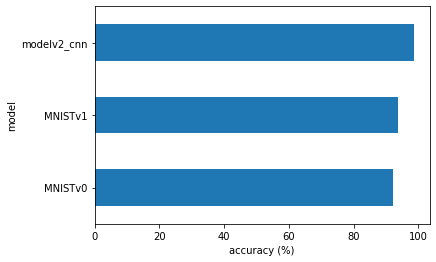

In [ ]:
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");